In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2
import glob
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 10))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims, cv2
import trackpy as tp
import moviepy
import imageio

In [3]:
##reads in sequence of images
##use pims.Video for videos but it is buggy

#could use line below, must be a path to a folder containing frames from a video
#frames = pims.ImageSequence('C:/Users/Jayson/Documents/College/Microbots - ML/trackpy/disso1-is/*.jpg')

# uses opencv to read the given avi file and convert it into a numpy array so we can change the frames
frames = pims.Video("disso1.avi")

deprecated pixel format used, make sure you did set range correctly


In [4]:
##converts frames to grey scale
@pims.pipeline
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

In [5]:
frames = as_grey(frames)

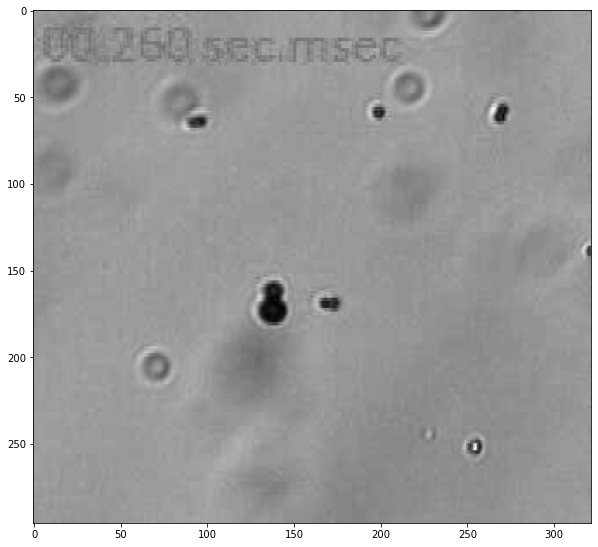

In [6]:
##1st frame
plt.imshow(frames[1])

In [7]:
##info of the frames
frames
#1790 frames
#90 fps

(PyAVReaderTimed,) processed through proc_func. Original repr:
    <Frames>
    Format: MJPEG (Motion JPEG)
    Source: disso1.avi
    Duration: 19.889 seconds
    Frame rate: 90.000 fps
    Length: 1790 frames
    Frame Shape: (296, 322, 3)
    

In [ ]:
print(frames[0])

In [8]:
##takes in a frame, 
#max size of the particle diameter-wise, change depending on microbot size
#invert = true bc features are darker than background
##returns a dataframe with potential particles
f = tp.locate(frames[0], 13, invert=True)

In [9]:
##.head shows first few rows of pandas dataframe
f.head()
#first two columns are x and y coordinates
#3rd is mass, means total integrated brightness of the blob
#4th is size the radius of gyration of its Gaussian-like profile
#ecc is eccentricity 
#no reference to signal raw_mass or ep in trackpy documentation
#frame is the frame number associated with the data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.013766,85.636185,163.915715,3.339228,0.382074,7.091732,-7082.6733,0.187575,0
1,13.274134,119.199705,218.715463,3.400009,0.353773,6.769381,-7129.1292,0.206309,0
2,12.979458,102.739496,172.619205,3.511885,0.461000,6.285853,-6926.7363,0.143757,0
3,13.571788,56.026029,191.960292,3.617988,0.493615,6.608205,-7163.9212,0.222989,0
4,14.128423,32.364495,170.685096,3.751235,0.377677,4.996448,-6818.4754,0.123696,0


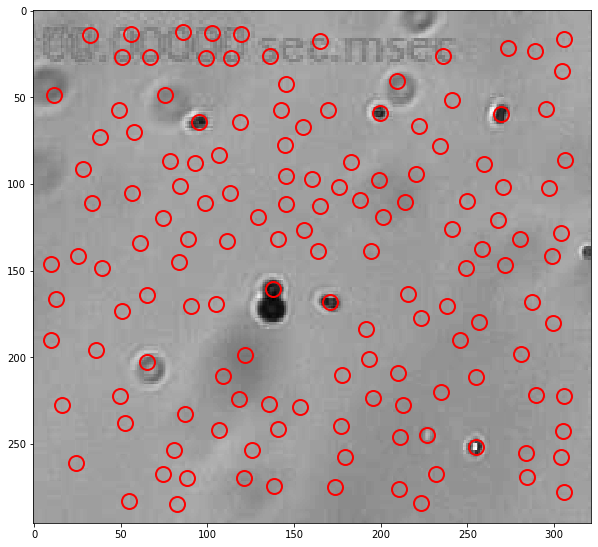

<AxesSubplot:>

In [10]:
plt.figure()  # make a new figure
##annotate searches for the particles and circles them
##this is just the first frame
tp.annotate(f, frames[0])
#it circles a lot of things, that is okay for now

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

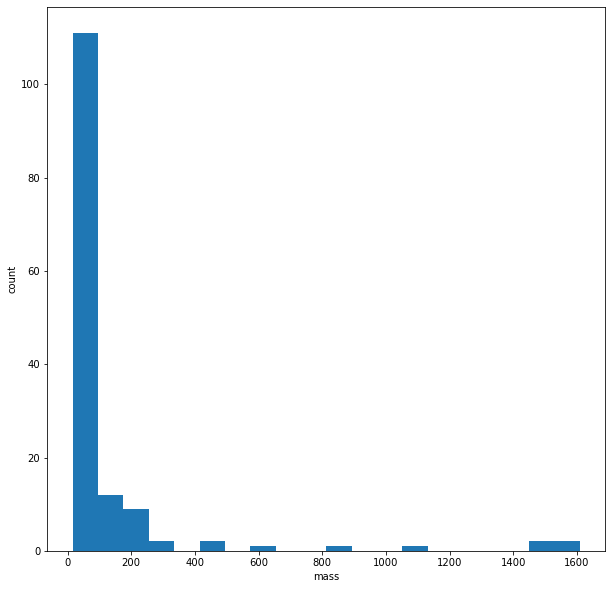

In [11]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
##plots the 'mass' of each detected particle
ax.set(xlabel='mass', ylabel='count')

In [12]:
f = tp.locate(frames[0], 13, invert=True, minmass=450)
##set min 'mass' to 450
#or any desired number to reduced the total number of annotated objects, making it precise

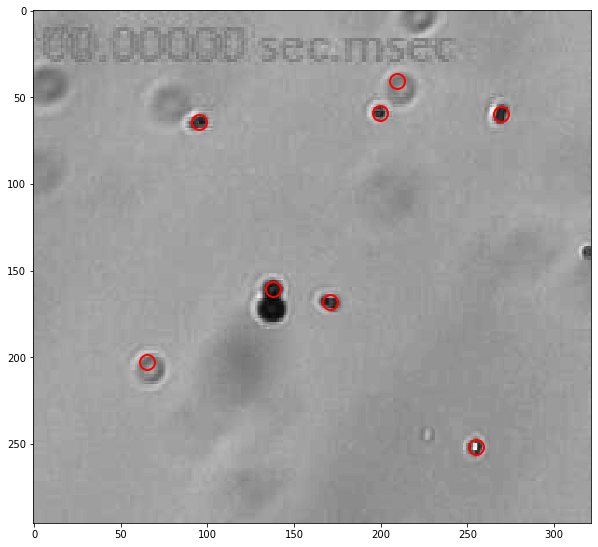

<AxesSubplot:>

In [13]:
##print image before manually dropping non-particles
tp.annotate(f, frames[0])

In [16]:
##batch does tp.locate on each frame
f = tp.batch(frames[:192], 13, minmass=450, invert=True, processes =1)

Frame 191: 10 features


[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

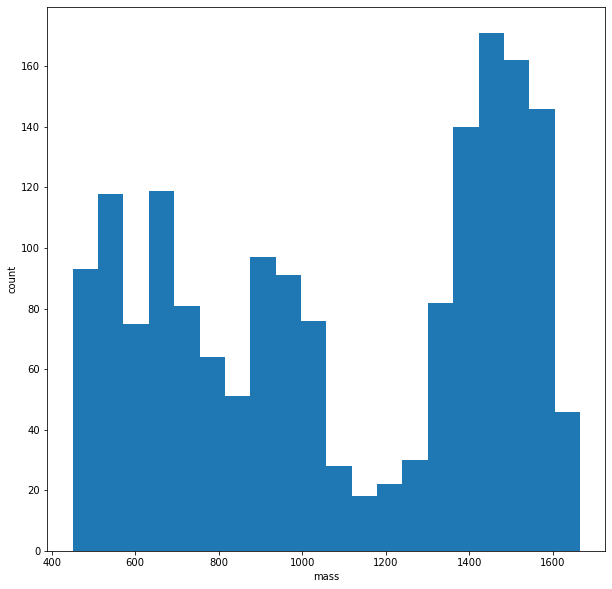

In [17]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
##plots the 'mass' of each detected particle
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

In [18]:
##pass in f
## second parameter is maximum displacement feature can between frames
## third is the most frames a particle can disappear before it is forgotten from memory
##returns a df
t = tp.link_df(f, 10, memory=10)

Frame 191: 10 trajectories present.


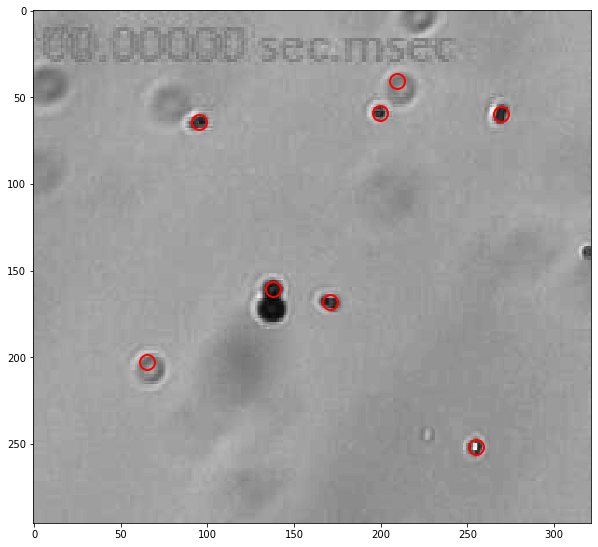

C:\Users\Jayson\AppData\Roaming\Python\Python37\site-packages\pims\pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


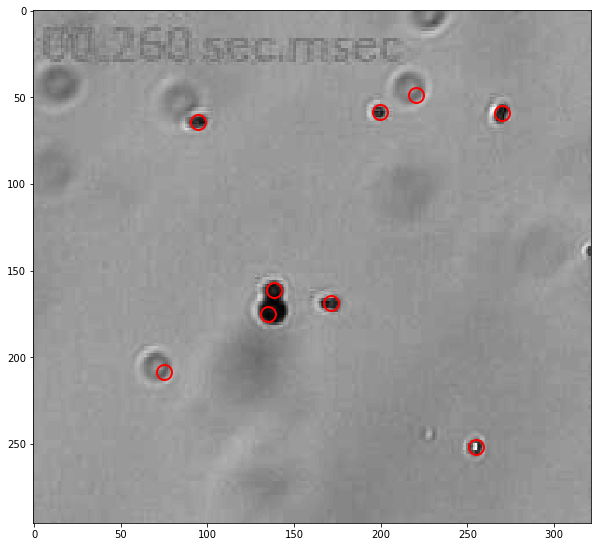

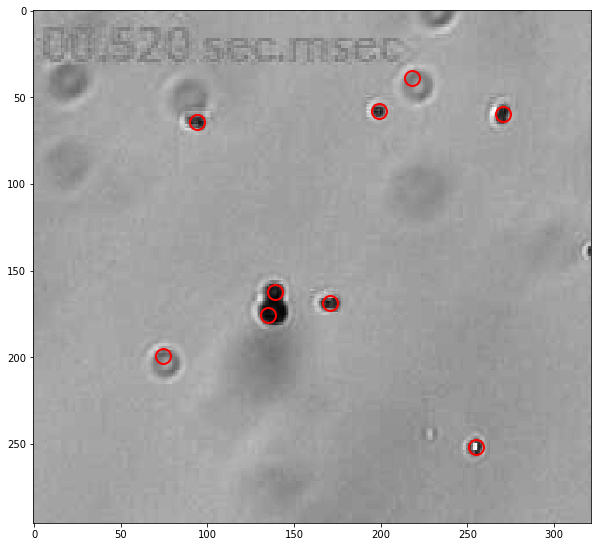

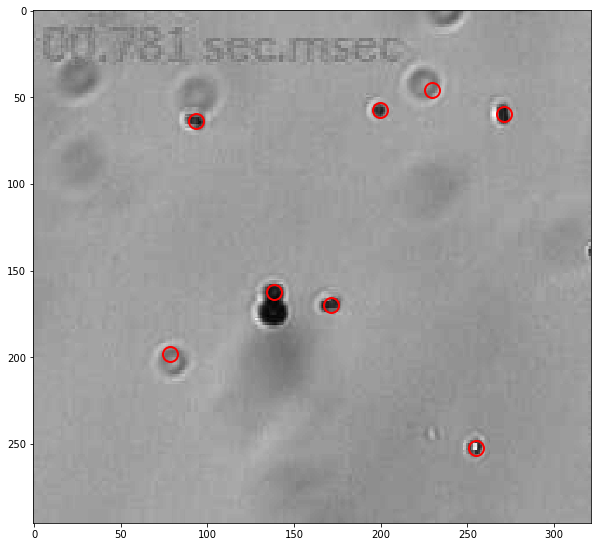

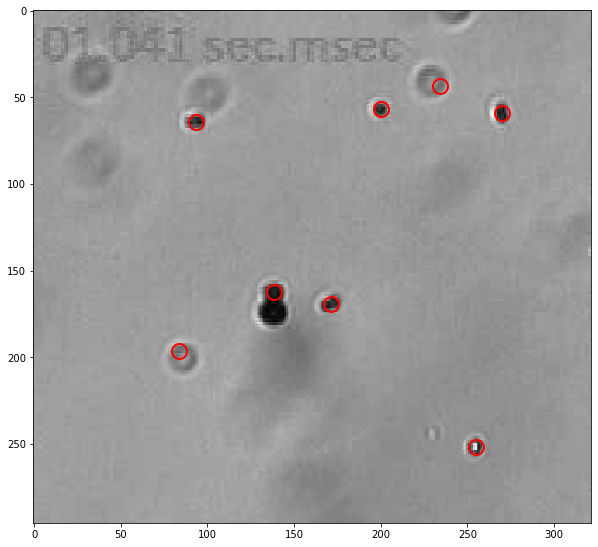

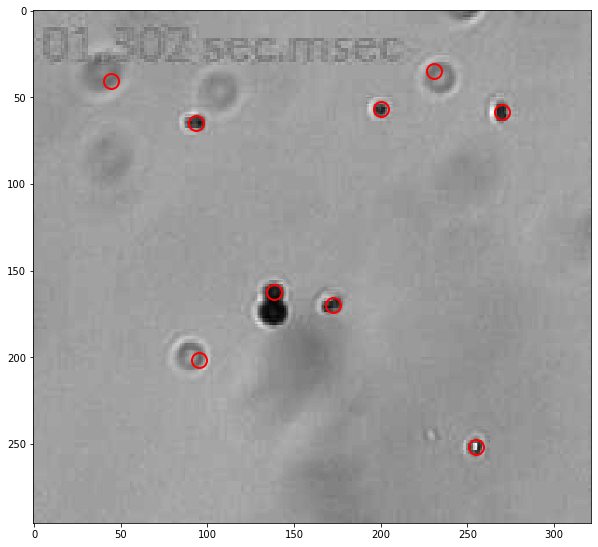

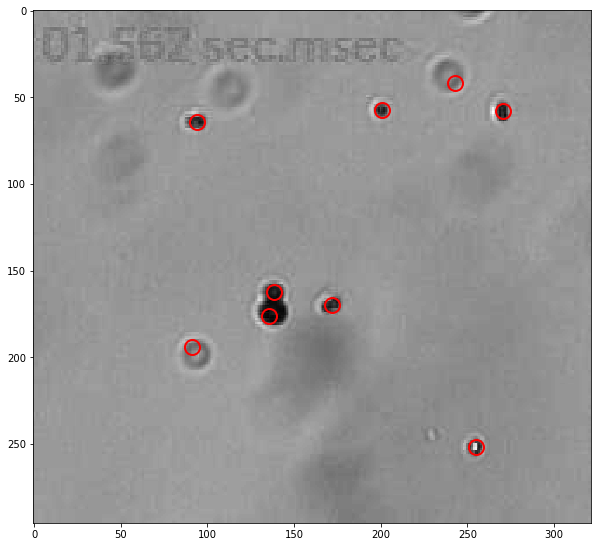

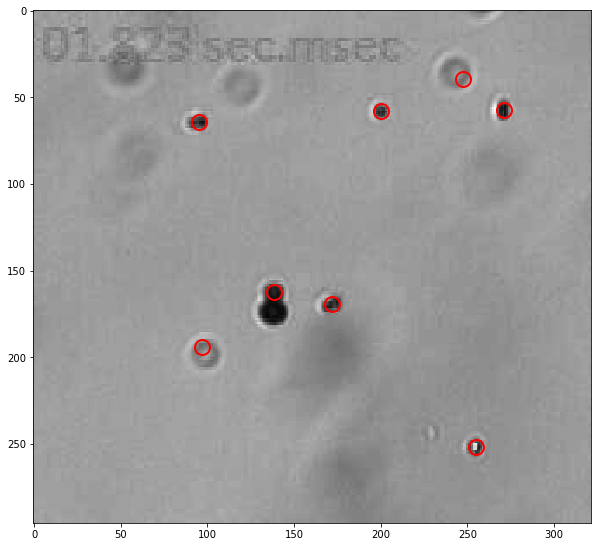

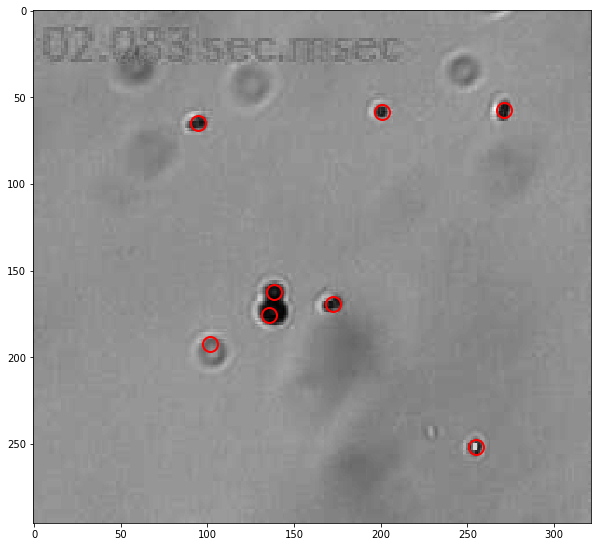

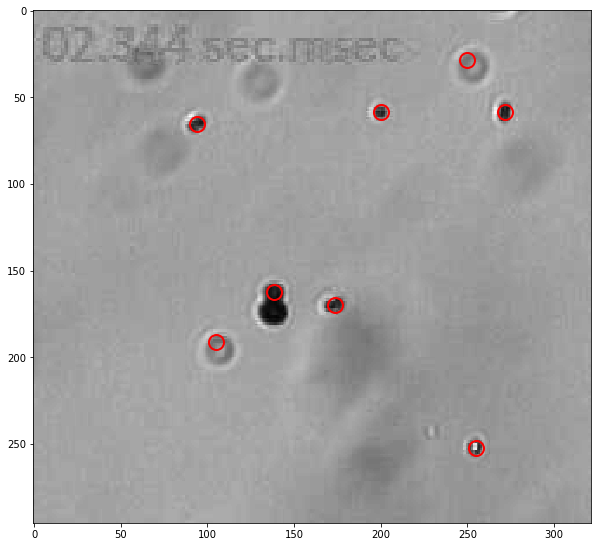

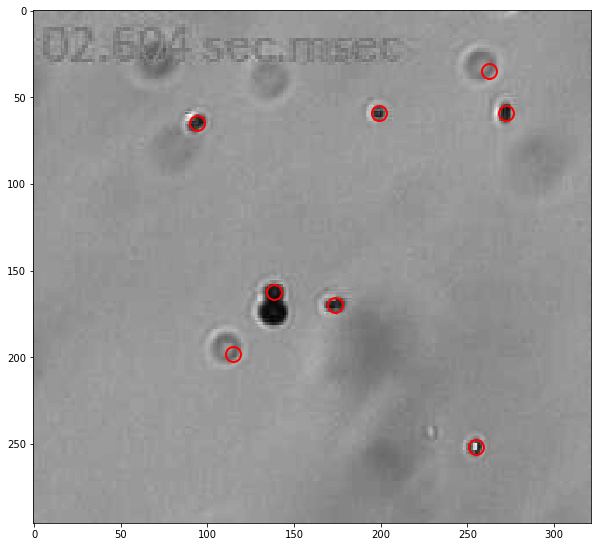

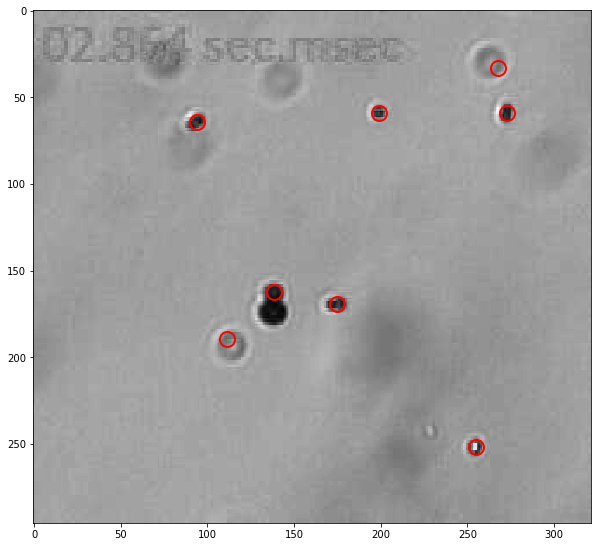

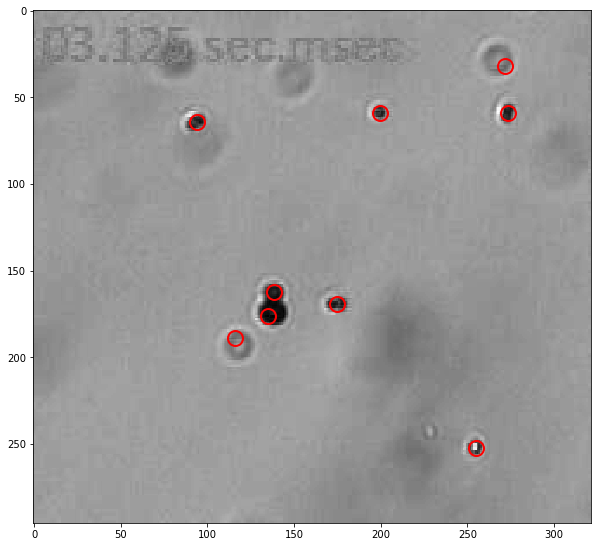

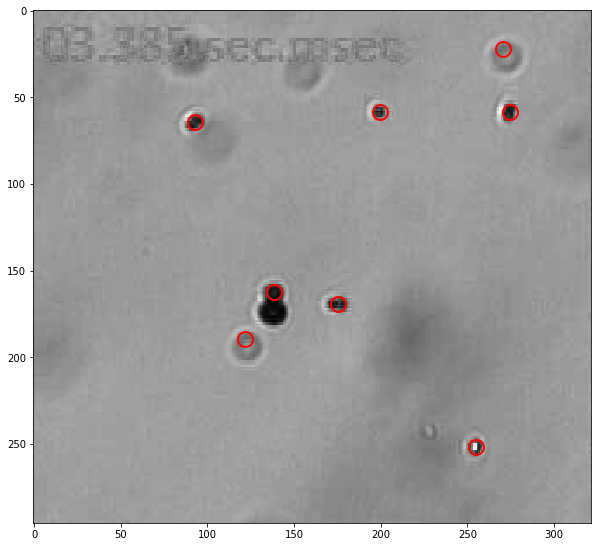

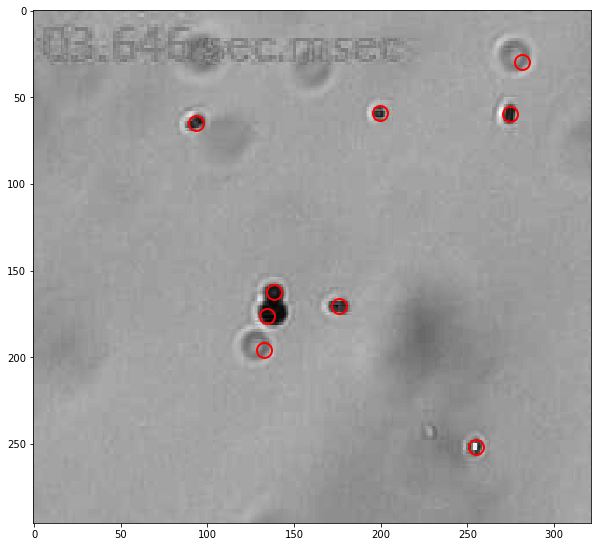

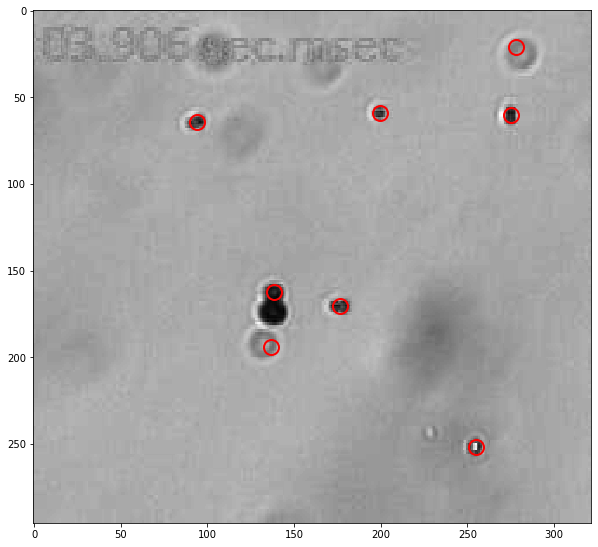

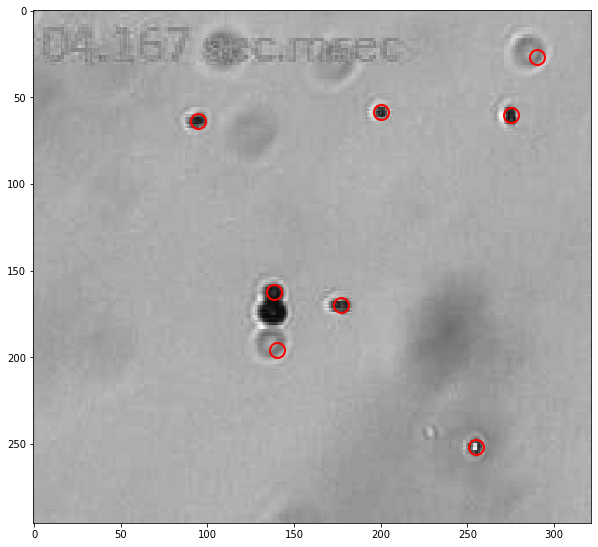

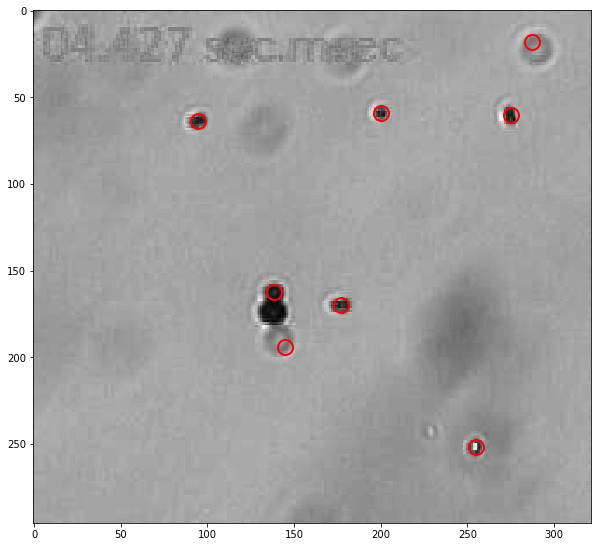

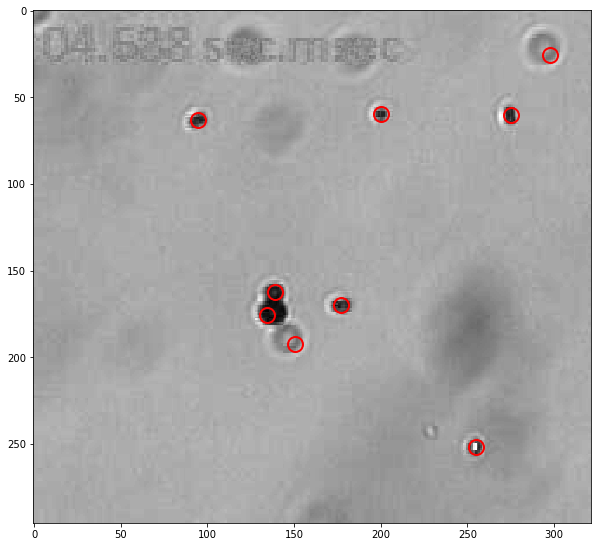

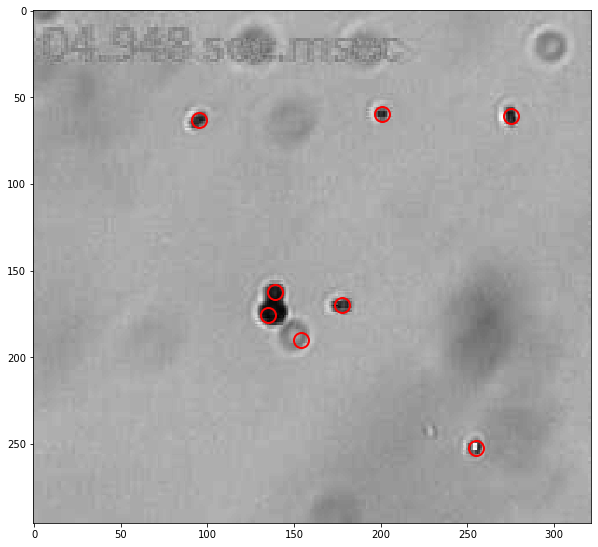

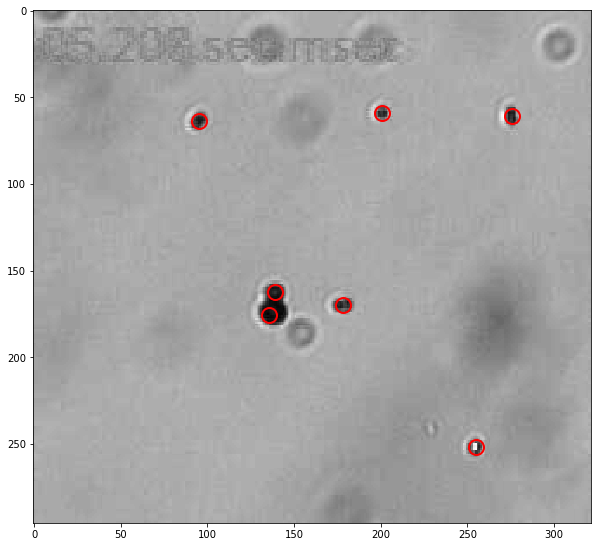

KeyboardInterrupt: 

In [19]:
##goes through and saves each annotated frame as a png
##will take a very long time
for i in range(199):
    tp.annotate(f.loc[f["frame"] == i], frames[i]).figure.savefig("tempframes/f" + str(i))

In [ ]:
##gets the annotated frames and turns them into a video
img_array = []
for filename in glob.glob('tempframes/*.png'):
    img = cv2.imread(filename)
    height,width, layers = img.shape
    size = (width,height)
    img_array.append(img)
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
###EVERYTHING BELOW IS EXPERIMENTAL

In [ ]:
#second param is minimum number of frames a feature must be in to survive
t1 = tp.filter_stubs(t, 15)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:

#t1 = t1[(t1.y < 50) & (t1.x <250)].index
plt.figure()
tp.mass_size(t1.groupby('particle').mean())

plt.figure()
tp.annotate(t1,frames[0])

In [ ]:
t1 = t1[(t1.y < 50)].index
t1

In [ ]:
##filters out bad annotations
condition = lambda x: ((x['mass'].mean() > 825) & (x['size'].mean() < 8) &
                       (x['ecc'].mean() > 0.1))
t2 = tp.filter(t1, condition)  # a wrapper for pandas' filter that works around a bug in v 0.12

In [ ]:
plt.figure()
tp.annotate(t2,frames[0])

In [ ]:
##plots movements 
plt.figure()
tp.plot_traj(t2)